In [1]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"]="1"
import jax.numpy as np
from jax import random, vmap, jit, value_and_grad, jacfwd
from jax.experimental.jet import jet
from jaxopt import OptaxSolver
from optax import adamw
from tqdm import trange
from NN import Siren, relative_l2
import matplotlib.pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True) # Enable double precision

In [2]:
# Model architecture
width = 50
layers = [1, width, width, width, 1]
w0=200.

# Optimizer and the number of steps
optimizer = adamw(5e-05)
nIter=10**4 * 5

# Plot
extent=[0,1,1,0]

Nx = 10000

In [3]:
# Define the model
class PINNs:
    def __init__(self, layers=[1,10,1], w0=10.):
        #Initialize
        self.PINN_init, self.PINN_apply = Siren(layers, w0)
        #Loggers
        self.train_log = []

    def PINN(self, params, x):
        input = np.stack([x])
        outputs = self.PINN_apply(params, input)
        return outputs[0]
    
    def PINN_res(self, params, x):
        u_fn = lambda x: self.PINN(params, x)
        u, (u_x, u_xx) = jet(u_fn, (x,), ((1., 0.),))
        return -u_xx * 1e-08 + u - 1

## 1D Singular Perturbation.

$-\epsilon^2 u''(x) + u(x) = 1 \text{ for } x\in (0,1)$, and zero Dirichlet boundary condition.

Here, we considered $\epsilon = 10^{-4}$.

Solution: $u(x) = 1- \frac{e^{-x/\epsilon} + e^{(x-1)/\epsilon}}{1+e^{-1/\epsilon}}$.

In [4]:
model = PINNs(layers=layers, w0=w0)
params_0 = model.PINN_init(random.PRNGKey(0))

@jit
def loss_pde(params, x_rd = np.linspace(0,1,Nx)):
    outputs = vmap(model.PINN_res, (None, 0))(params, x_rd)
    mse = np.mean( outputs**2 )
    return mse

@jit
def loss_bc(params, x_bd = np.linspace(0,1,2)):
    outputs = vmap(model.PINN, (None, 0))(params, x_bd)
    mse = np.mean( outputs**2 )
    return mse

@jit
def loss(params):
    return (loss_pde(params) + loss_bc(params))

def train(maxiter, state, update, init_params):
    total_log, pde_log, bc_log = [], [], []
    pbar = trange(maxiter)
    params = init_params
    min_loss = 1e+08
    for it in pbar:
        params, state = update(params, state)
        if it%100 == 0:
            total_loss = state.value
            total_log.append(total_loss)
            pde_loss = loss_pde(params)
            pde_log.append(pde_loss)
            bc_loss = loss_bc(params)
            bc_log.append(bc_loss)
            if min_loss > total_loss:
                min_loss = total_loss
                opt_params = params
        # Print losses during training
        pbar.set_postfix({'total': min_loss, 'pde':pde_loss, 'bc':bc_loss})
    return opt_params, total_log, pde_log, bc_log

solver = OptaxSolver(fun=value_and_grad(loss), opt=optimizer, value_and_grad=True)
state = solver.init_state(params_0)
update = jit(solver.update)
opt_params, *logs = train(nIter, state, update, params_0)

100%|██████████| 50000/50000 [06:18<00:00, 131.98it/s, total=0.00016968395913622512, pde=0.0004930980048898555, bc=0.0010834570747504354]  


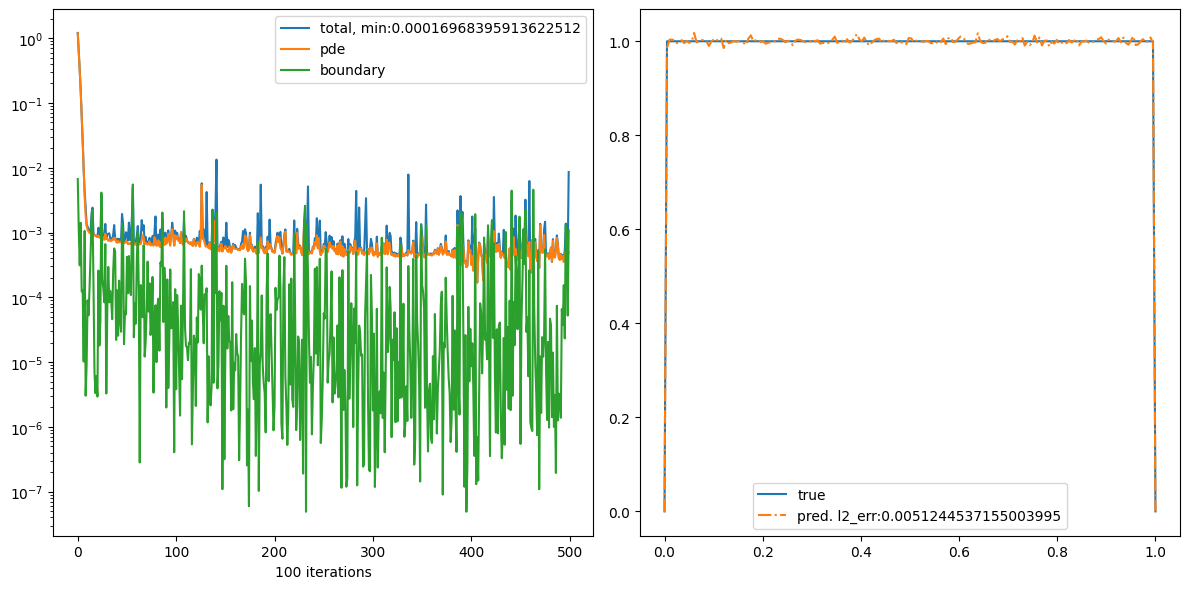

In [5]:
x = np.linspace(0,1,200) # we can reduce relative l2 error by 2*Nx -> 200.
u_pred = vmap(model.PINN, (None, 0))(opt_params, x)

def solution(x, epsilon=1e-04):
    return 1 - (np.exp(-x/epsilon) + np.exp((x-1)/epsilon))/(1+np.exp(-1/epsilon))

l2_error = relative_l2(u_pred, solution(x))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.semilogy(logs[0], label='total, min:'+str(min(logs[0])))
plt.semilogy(logs[1], label='pde')
plt.semilogy(logs[2], label='boundary')
plt.xlabel('100 iterations')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(x, solution(x), label='true')
plt.plot(x, u_pred, '-.', label='pred. l2_err:'+str(l2_error))
plt.legend()
plt.tight_layout()
plt.show()